# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pandas as pd
import re
import unidecode

from datetime import datetime
from joblib import dump, load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from string import punctuation

In [2]:
import warnings
warnings.filterwarnings("ignore") 

## Constantes e funções auxiliares

In [3]:
# arquivo com amostras rotuladas já tratadas
FILE_ANUNCIOS_ROTULADOS = '../datasets/rotulagem_consolidada/fiscaliza/anuncios_rotulados.parquet'

# arquivo com amostras rotuladas já tratadas, com acréscimo das categorias extraídas 
FILE_ANUNCIOS_ROTULADOS_CATEGORIA = '../datasets/rotulagem_consolidada/regulatron/tratados/anuncios_rotulados_categoria.parquet'

# planilha com resultados da fiscalização de supervisão de mercado
FILE_SUPERVISAO_MERCADO = '../datasets/rotulagem_consolidada/supervisao_mercado/supervisao_mercado.xlsx'

# modelo de classificação do experimento 3
FILE_MODEL_CLF3 = '../experimentos/assets/exp_clf3_model.joblib'

In [4]:
def load_file_mercado(file_mercado=FILE_SUPERVISAO_MERCADO):
    dict_df_mercado = pd.read_excel(
    file_mercado,
    sheet_name=None,
    usecols=[2,8,10,11],
    names=['texto_busca', 'titulo', 'passivel_homologacao', 'tipo_produto'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

    df_list = []
    for key in dict_df_mercado.keys():
        df = dict_df_mercado[key]
        df['marketplace'] = key
        df_list.append(df)
        
    df_mercado = pd.concat(df_list)
    df_mercado['tipo_produto'] = df_mercado['tipo_produto'].fillna('')
    df_mercado = df_mercado.dropna()
    df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)
    
    map_marketplaces = {
        'Amazon': 'Amazon', 
        'Americanas': 'Lojas Americanas',
        'CasasBahia': 'Casas Bahia',
        'Magalu': 'Magazine Luiza', 
        'MercadoLivre': 'Mercado Livre'
    }
    
    df_mercado['marketplace'] = df_mercado['marketplace'].map(map_marketplaces)

    return df_mercado

In [5]:
def plot_model_performance(model, desc=None):
    
    clf_name = model['clf'].__class__.__name__
    if desc is None:
        clf_desc = ''
    else:
        clf_desc = desc
    
    # test accuracy and roc_auc_score
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
    valid_accuracy = model.score(X_valid,y_valid)
    valid_tipo_accuracy = model.score(X_valid_tipo,y_valid)
    
    if hasattr(model['clf'],'predict_proba'):
        y_train_proba = model.predict_proba(X_test)[:,1]
        y_test_proba = model.predict_proba(X_test)[:,1]
        y_valid_proba = model.predict_proba(X_valid)[:,1]
        y_valid_tipo_proba = model.predict_proba(X_valid_tipo)[:,1]
    else:
        y_train_proba = model.decision_function(X_test)
        y_test_proba = model.decision_function(X_test)
        y_valid_proba = model.decision_function(X_valid)
        y_valid_tipo_proba = model.decision_function(X_valid_tipo)
        
    train_auc = roc_auc_score(y_test,y_test_proba)
    test_auc = roc_auc_score(y_test,y_test_proba)
    valid_auc = roc_auc_score(y_valid,y_valid_proba)
    valid_tipo_auc = roc_auc_score(y_valid,y_valid_tipo_proba)
    
    
    print('Accuracy of {} classifier on training set: {:.3f}'.format(clf_name, train_accuracy))
    print('Accuracy of {} classifier on test set: {:.3f}'.format(clf_name, test_accuracy))
    print('Accuracy of {} classifier on validation set: {:.3f}'.format(clf_name, valid_accuracy))
    print('Accuracy of {} classifier on validation extra set: {:.3f}'.format(clf_name, valid_tipo_accuracy))
    print('')
    print('AUC of {} classifier on training set: {:.3f}'.format(clf_name, train_auc))
    print('AUC of {} classifier on test set: {:.3f}'.format(clf_name, test_auc))
    print('AUC of {} classifier on validation set: {:.3f}'.format(clf_name, valid_auc))
    print('AUC of {} classifier on validation extra set: {:.3f}'.format(clf_name, valid_tipo_auc))
    print('')

    # test confusion matrix
    y_pred_test = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred_test)
    tn = int(cm[0][0])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    fp = int(cm[0][1])
    
    test_confusion = {
        'tn': tn, 
        'fn': fn, 
        'tp': tp, 
        'fp': fp
    }
    
    # validation confusion matrix
    y_pred_valid = model.predict(X_valid)
    cm = confusion_matrix(y_valid,y_pred_valid)
    tn = int(cm[0][0])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    fp = int(cm[0][1])
    
    valid_confusion = {
        'tn': tn, 
        'fn': fn, 
        'tp': tp, 
        'fp': fp
    }

    # validation extra confusion matrix
    y_pred_valid_tipo = model.predict(X_valid_tipo)
    cm = confusion_matrix(y_valid,y_pred_valid_tipo)
    tn = int(cm[0][0])
    fn = int(cm[1][0])
    tp = int(cm[1][1])
    fp = int(cm[0][1])
    
    valid_tipo_confusion = {
        'tn': tn, 
        'fn': fn, 
        'tp': tp, 
        'fp': fp
    }
    
    model_performance = {
        'name': clf_name,
        'desc': clf_desc,
        'train_auc': train_auc,
        'train_accuracy': train_accuracy,
        'test_auc': test_auc, 
        'test_accuracy': test_accuracy,
        'test_confusion': json.dumps(valid_confusion),
        'valid_auc': valid_auc,
        'valid_accuracy': valid_accuracy,
        'valid_confusion': json.dumps(valid_confusion),
        'valid_tipo_auc': valid_tipo_auc,
        'valid_tipo_accuracy': valid_tipo_accuracy,
        'valid_tipo_confusion': json.dumps(valid_tipo_confusion),
        'model': model
    }

    target_names_confusion = ['Não passíveis\nde homologação','Passíveis\nde homologação']
    
    fig, axs = plt.subplots(1,2,figsize=(16, 5))
    ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid, ax=axs[0])
    axs[0].set_xlabel('Verdadeiro')
    axs[0].set_ylabel('Predito')
    axs[0].xaxis.set_ticklabels(target_names_confusion)
    axs[0].yaxis.set_ticklabels(target_names_confusion)
    _ = axs[0].set_title(f'Matriz de Confusão {clf_name}\nConjunto de Validação')
    
    ConfusionMatrixDisplay.from_predictions(y_valid, y_pred_valid_tipo, ax=axs[1])
    axs[1].set_xlabel('Verdadeiro')
    axs[1].set_ylabel('Predito')
    axs[1].xaxis.set_ticklabels(target_names_confusion)
    axs[1].yaxis.set_ticklabels(target_names_confusion)
    _ = axs[1].set_title(f'Matriz de Confusão {clf_name}\nConjunto Extra de Validação')
    
    plt.show()

    return model_performance

In [6]:
def plot_models_benchmark(models, df):

    results = []
    docs = df['titulo']
    targets = df['passivel_homologacao']

    print('=' * 40)
    for model, name in models:
        
        acc = model.score(docs, targets)
        auc = roc_auc_score(targets,model.predict_proba(docs)[:,1])
        y_scores = model.decision_function(docs)
        fpr,tpr,auc_thresholds = roc_curve(targets,y_scores)
    
        model_results = {
            'name': name, 
            'acc': acc, 
            'auc': auc, 
            'fpr': fpr, 
            'tpr': tpr, 
            'auc_thresholds': auc_thresholds
        }
        
        results.append(model_results)
        
        print(name)
        print(f'Acurácia: {acc:.3f}')
        print('_' * 40)
        print()

    fig, ax = plt.subplots(1,1,figsize=(6,6))

    for result in results:

        name = result['name'] 
        auc = result['auc']
        fpr = result['fpr']
        tpr = result['tpr']
    
        ax.plot(fpr,tpr,label=f'{name}: {auc:.3f}')
  
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    
    # remove the frame of the chart
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_title('Curva ROC')
    ax.set_xlabel('Taxa de falsos positivos')
    ax.set_ylabel('Taxa de verdadeiros positivos')
    
    ax.legend(loc='lower right')
    
    plt.show()

    return results, fig

In [7]:
def save_best_estimator():
    best_estimator_class_name = gs.best_estimator_['clf'].__class__.__name__
    best_estimator_file_name = f'{MODELS_FOLDER}{best_estimator_class_name}.joblib'
    dump(gs.best_estimator_,best_estimator_file_name)

# Carga e prepação dos dados

In [8]:
df_anuncios = pd.read_parquet(FILE_ANUNCIOS_ROTULADOS_CATEGORIA)
df_anuncios = df_anuncios[df_anuncios['passivel_homologacao']<2]
df_mercado = load_file_mercado()

# reduzir a base de dados para construir o notebook
# df_marketplaces = df_marketplaces.sample(10)

# conjunto de dados
docs = df_anuncios['titulo'].values
targets = df_anuncios[df_anuncios['passivel_homologacao']<2]['passivel_homologacao'].values

# Split data to keep experiment results comparable
X_train, X_test, y_train, y_test = train_test_split(
    docs, targets,
    test_size=0.25, 
    random_state=724
)

X_valid, y_valid = df_mercado['titulo'].values, df_mercado['passivel_homologacao'].values
X_valid_tipo = df_mercado[['titulo','tipo_produto']].apply(lambda row: ' '.join(row),axis=1).values

# Análise


## Treinamento com dados originais

In [9]:
# lista para armazenar os modelos treinados
models = []

In [10]:
# vetorizador: não se altera entre os modelos
# stop words
stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

### LogisticRegression

Accuracy of LogisticRegression classifier on training set: 0.997
Accuracy of LogisticRegression classifier on test set: 0.920
Accuracy of LogisticRegression classifier on validation set: 0.902
Accuracy of LogisticRegression classifier on validation extra set: 0.904

AUC of LogisticRegression classifier on training set: 0.973
AUC of LogisticRegression classifier on test set: 0.973
AUC of LogisticRegression classifier on validation set: 0.957
AUC of LogisticRegression classifier on validation extra set: 0.970



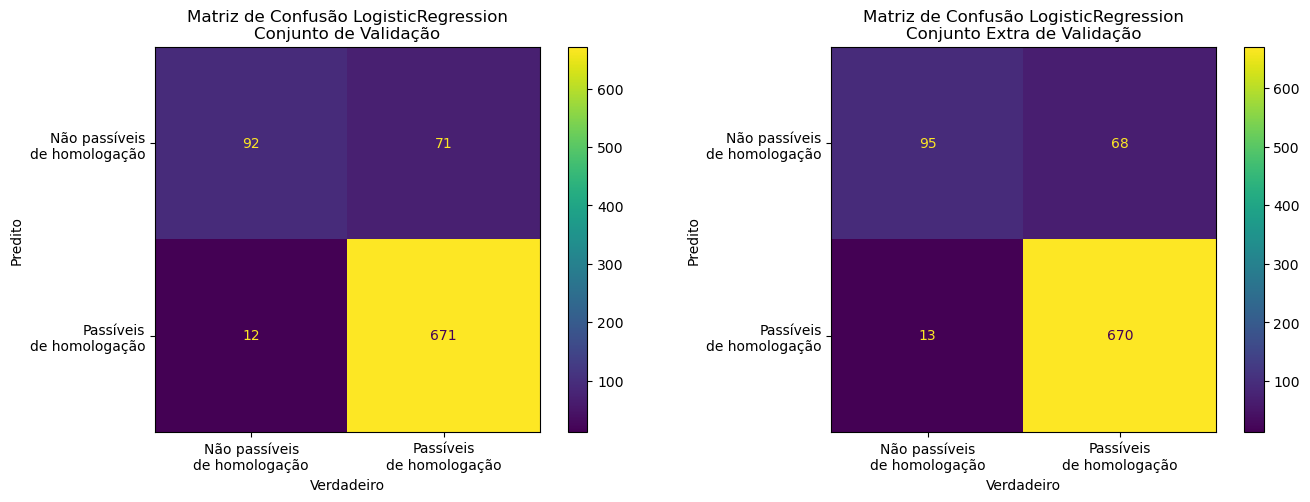

CPU times: total: 5.09 s
Wall time: 3.38 s


In [11]:
%%time

vectorizer_logistic = TfidfVectorizer(
    stop_words=stop_words,
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)
clf_logistic = LogisticRegression(C=10)
model_logistic = Pipeline(steps = [('vectorizer',vectorizer_logistic),('clf',clf_logistic)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_logistic.fit(X_train,y_train)

models.append(plot_model_performance(model_logistic,'Experimento atual'))

### LinearSVC

Accuracy of LinearSVC classifier on training set: 0.998
Accuracy of LinearSVC classifier on test set: 0.922
Accuracy of LinearSVC classifier on validation set: 0.900
Accuracy of LinearSVC classifier on validation extra set: 0.903

AUC of LinearSVC classifier on training set: 0.972
AUC of LinearSVC classifier on test set: 0.972
AUC of LinearSVC classifier on validation set: 0.955
AUC of LinearSVC classifier on validation extra set: 0.968



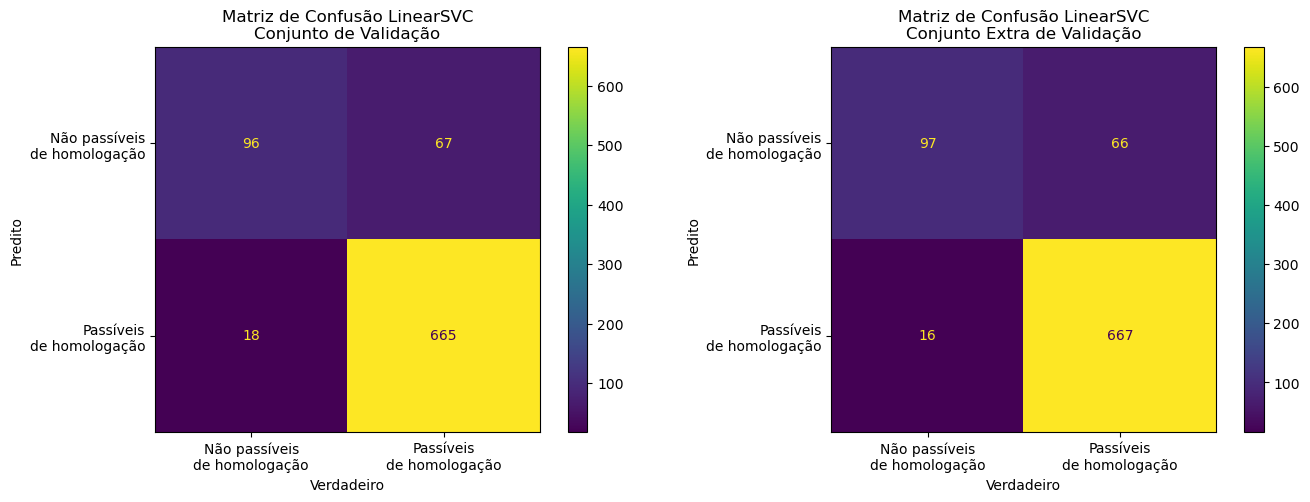

CPU times: total: 1.56 s
Wall time: 2.41 s


In [12]:
%%time

vectorizer_linearsvc = TfidfVectorizer(
    stop_words=stop_words,
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)
clf_linearsvc = LinearSVC()
model_linearsvc = Pipeline(steps = [('vectorizer',vectorizer_linearsvc),('clf',clf_linearsvc)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_linearsvc.fit(X_train,y_train)

models.append(plot_model_performance(model_linearsvc,'Experimento atual'))

### SGDClassifier

Accuracy of SGDClassifier classifier on training set: 0.996
Accuracy of SGDClassifier classifier on test set: 0.919
Accuracy of SGDClassifier classifier on validation set: 0.900
Accuracy of SGDClassifier classifier on validation extra set: 0.902

AUC of SGDClassifier classifier on training set: 0.972
AUC of SGDClassifier classifier on test set: 0.972
AUC of SGDClassifier classifier on validation set: 0.955
AUC of SGDClassifier classifier on validation extra set: 0.969



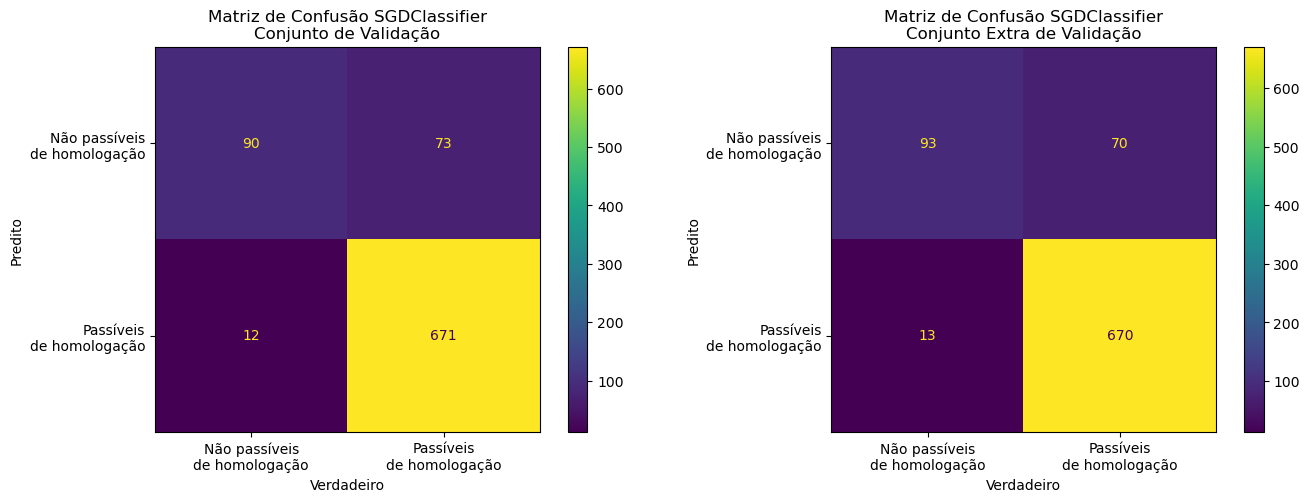

CPU times: total: 2.31 s
Wall time: 2.51 s


In [13]:
%%time

vectorizer_sgd = TfidfVectorizer(
    stop_words=stop_words,
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)
clf_sgd = SGDClassifier(loss = 'log_loss', alpha = 1e-05)
model_sgd = Pipeline(steps = [('vectorizer',vectorizer_sgd),('clf',clf_sgd)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_sgd.fit(X_train,y_train)

models.append(plot_model_performance(model_sgd,'Experimento atual'))

### NuSVC

Accuracy of NuSVC classifier on training set: 0.999
Accuracy of NuSVC classifier on test set: 0.922
Accuracy of NuSVC classifier on validation set: 0.902
Accuracy of NuSVC classifier on validation extra set: 0.907

AUC of NuSVC classifier on training set: 0.971
AUC of NuSVC classifier on test set: 0.971
AUC of NuSVC classifier on validation set: 0.955
AUC of NuSVC classifier on validation extra set: 0.969



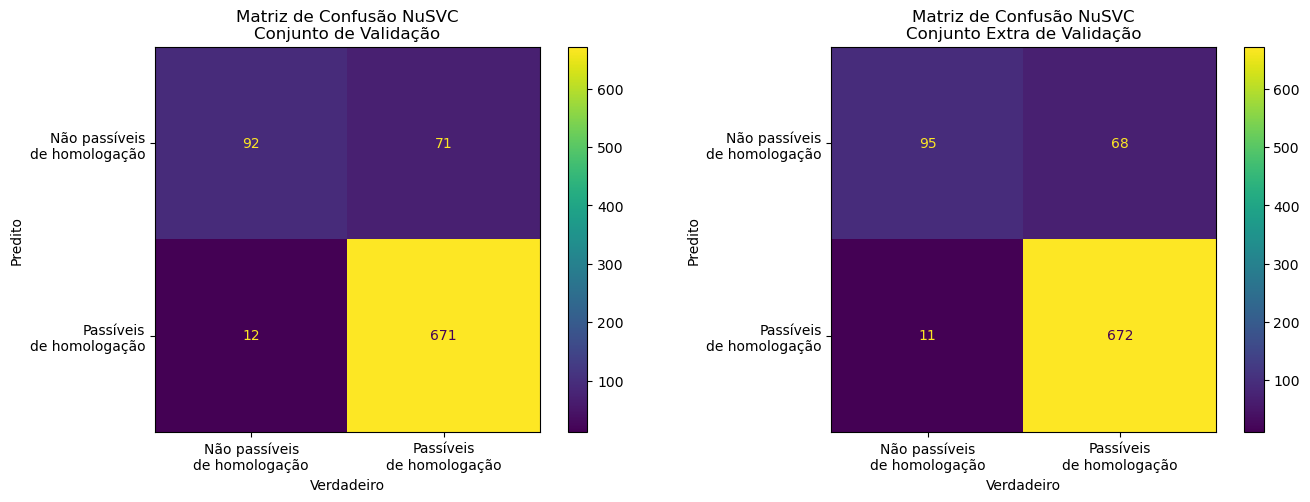

CPU times: total: 1min 9s
Wall time: 1min 26s


In [14]:
%%time

vectorizer_nusvc = TfidfVectorizer(
    stop_words=stop_words,
    strip_accents = 'unicode', 
    ngram_range = (1,2)
)
clf_nusvc = NuSVC(nu = 0.25, tol = 0.01)
model_nusvc = Pipeline(steps = [('vectorizer',vectorizer_nusvc),('clf',clf_nusvc)])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_nusvc.fit(X_train,y_train)

models.append(plot_model_performance(model_nusvc,'Experimento atual'))

### SGD do Experimento de Classificação 3

Accuracy of SGDClassifier classifier on training set: 0.993
Accuracy of SGDClassifier classifier on test set: 0.918
Accuracy of SGDClassifier classifier on validation set: 0.904
Accuracy of SGDClassifier classifier on validation extra set: 0.909

AUC of SGDClassifier classifier on training set: 0.972
AUC of SGDClassifier classifier on test set: 0.972
AUC of SGDClassifier classifier on validation set: 0.959
AUC of SGDClassifier classifier on validation extra set: 0.973



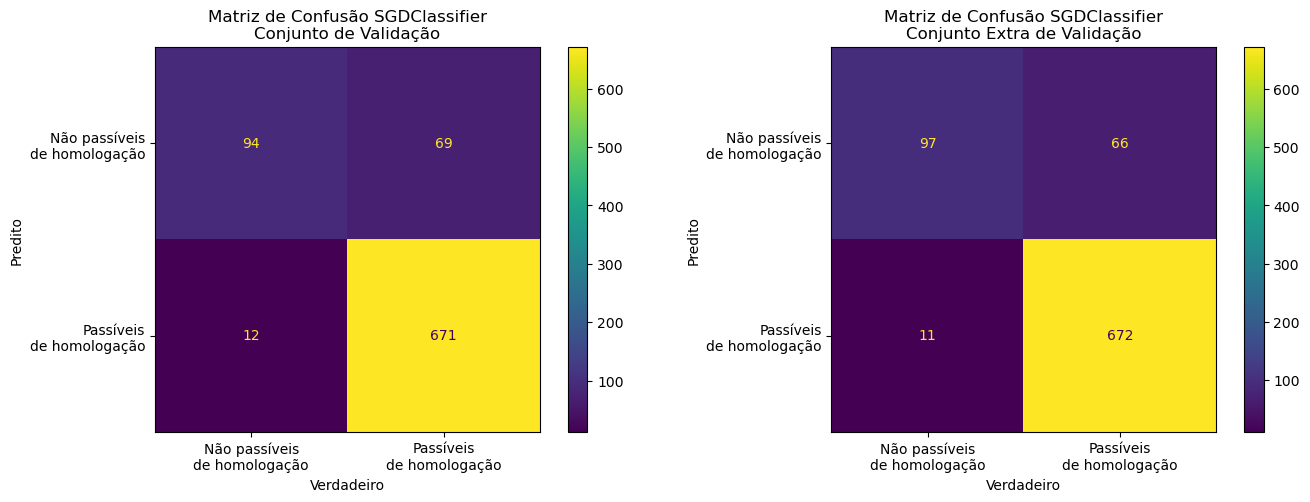

In [15]:
model_clf3 = load(FILE_MODEL_CLF3)
models.append(plot_model_performance(model_clf3, 'Experimento 3'))

# Resultados da validação

In [16]:
df_models = pd.DataFrame(models)
df_models = df_models.sort_values(by=['valid_tipo_auc','valid_tipo_accuracy'], ascending = False)
df_models = df_models.reset_index(drop=True)

columns_to_keep = [
    'name', 'desc', 
    'valid_auc', 'valid_accuracy', 'valid_confusion',
    'valid_tipo_auc', 'valid_tipo_accuracy', 'valid_tipo_confusion',
    'model']
df_models[columns_to_keep].sort_values(by='valid_auc',ascending=False)

,name,desc,valid_auc,valid_accuracy,valid_confusion,valid_tipo_auc,valid_tipo_accuracy,valid_tipo_confusion,model
0,SGDClassifier,Experimento 3,0.959265,0.904255,"{""tn"": 94, ""fn"": 12, ""tp"": 671, ""fp"": 69}",0.972685,0.908983,"{""tn"": 97, ""fn"": 11, ""tp"": 672, ""fp"": 66}","(CountVectorizer(ngram_range=(1, 2),\n ..."
1,LogisticRegression,Experimento atual,0.957208,0.901891,"{""tn"": 92, ""fn"": 12, ""tp"": 671, ""fp"": 71}",0.970241,0.904255,"{""tn"": 95, ""fn"": 13, ""tp"": 670, ""fp"": 68}","(TfidfVectorizer(ngram_range=(1, 2),\n ..."
3,SGDClassifier,Experimento atual,0.955124,0.899527,"{""tn"": 90, ""fn"": 12, ""tp"": 671, ""fp"": 73}",0.968651,0.901891,"{""tn"": 93, ""fn"": 13, ""tp"": 670, ""fp"": 70}","(TfidfVectorizer(ngram_range=(1, 2),\n ..."
2,NuSVC,Experimento atual,0.955007,0.901891,"{""tn"": 92, ""fn"": 12, ""tp"": 671, ""fp"": 71}",0.968858,0.906619,"{""tn"": 95, ""fn"": 11, ""tp"": 672, ""fp"": 68}","(TfidfVectorizer(ngram_range=(1, 2),\n ..."
4,LinearSVC,Experimento atual,0.954738,0.899527,"{""tn"": 96, ""fn"": 18, ""tp"": 665, ""fp"": 67}",0.967897,0.903073,"{""tn"": 97, ""fn"": 16, ""tp"": 667, ""fp"": 66}","(TfidfVectorizer(ngram_range=(1, 2),\n ..."
